# TP Deep Clustering 


<img src="https://drive.google.com/uc?id=13dN55x2iT_Y29SRkq4748SxaYLfgt_Kp" width="1200">


L'objectif de ce TP consiste à créer un modèle constitué de plusieurs parties :

- Un auto-codeur, pré-entraîné pour apprendre la représentation condensée initiale des jeux de données non étiquetés.
- Une couche de clustering empilée sur l'encodeur pour affecter la sortie de l'encodeur à un cluster. Les poids de la couche de clustering sont initialisés avec les centres de cluster de K-Means basés sur l'évaluation actuelle.
- Entraîner le modèle de clustering pour affiner la couche de clustering et le codeur conjointement.


In [1]:
from time import time
import numpy as np
import keras.backend as K
from keras.layers import Dense, Input, Layer, InputSpec,  Conv2D, MaxPooling2D, UpSampling2D, Flatten, Reshape, Conv2DTranspose
from keras.models import Model
from keras.initializers import VarianceScaling
from sklearn.cluster import KMeans
from sklearn.cluster import MiniBatchKMeans
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn import metrics
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

2024-11-26 09:40:07.984575: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-26 09:40:08.018850: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2024-11-26 09:40:08.200398: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-11-26 09:40:08.200457: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-11-26 09:40:08.201527: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to regi

# Chargement des données

In [7]:
from keras.datasets import mnist
from keras.datasets import fashion_mnist # à tester, + complexe que l'ensemble mnist 

import numpy as np

# Chargement et normalisation (entre 0 et 1) des données de la base de données MNIST/Fashion mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

x_trainIm = x_train.astype('float32') / 255.
x_testIm = x_test.astype('float32') / 255.

x_train = np.reshape(x_trainIm, (len(x_train), 784))
x_test = np.reshape(x_testIm, (len(x_test), 784))

# Nombre de classes à trouver
n_clusters=10

# Baseline par clustering classique par kmeans

In [18]:
# nombre de chiffres
n_digits = len(np.unique(y_test))

# Initialisation du Kmeans 
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Appliquer Kmeans sur base d'apprentissage
y_pred_kmeans=kmeans.fit_predict(x_train)

/home/felix/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


In [19]:
# Score de performance
accuracy_score(y_train, y_pred_kmeans)

0.04468333333333333

## Attribution des étiquettes de cluster

La classification K-means est une méthode d'apprentissage automatique non supervisée ; par conséquent, les étiquettes attribuées par notre algorithme KMeans font référence à la classification à laquelle chaque tableau a été attribué, et non à l'entier cible réel. Pour résoudre ce problème, définissons quelques fonctions qui prédiront quel nombre entier correspond à chaque cluster.

In [20]:
def retrieve_info(cluster_labels,y_train):
 #Associe l'étiquette la plus probable à chaque groupe dans le modèle KMeans.
 #Résultats : dictionnaire des clusters associés à chaque étiquette.

# Initialisation
  reference_labels = np.zeros((len(np.unique(cluster_labels)),1))
# Loop pour chaque label 
  for i in range(len(np.unique(cluster_labels))):
    index = np.where(cluster_labels == i,1,0)
    num = np.bincount(y_train[index==1]).argmax()
    reference_labels[i] = num
  return reference_labels

In [21]:
def correspondance(y_pred_kmeans,y_train):
  # Correspondance entre la partition et les classes de la vérité terrain
  reference_labels = retrieve_info(y_pred_kmeans,y_train)
  number_labels = np.zeros(len(y_pred_kmeans))
  for i in range(len(y_pred_kmeans)):
    number_labels[i] = reference_labels[y_pred_kmeans[i]]
  return number_labels


In [22]:
# Score de performance sur l'apprentissage après correspondance entre les classes
accuracy_score(y_train,correspondance(y_pred_kmeans,y_train))

/tmp/ipykernel_38264/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


0.51935

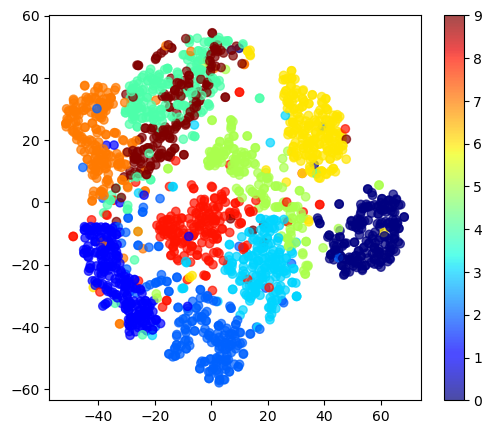

In [74]:
# Affichage des données 
count=2000
ListeData = np.random.choice(len(x_test), count)
inputs = x_train[ListeData]
classes = y_train[ListeData]

# Appliquer une réduction de données en 2D via la TSNE
tsne = TSNE(n_components=2)
#tsne = PCA(n_components=2)
coordsTSNE = tsne.fit_transform(inputs)

# Affichage des données
plt.figure(figsize=(6, 5))
plt.scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=classes, cmap='jet', alpha=0.7)
plt.colorbar()
plt.show()

# Autoencodeur classique à définir 

In [77]:
# Architecture de l'autoencodeur
input_img = Input(shape=(x_train.shape[1],))
n_latent = 10
# Encoder
encoded = Dense(500, activation='relu')(input_img)
encoded = Dense(300, activation='relu')(encoded)
encoded = Dense(n_latent, activation='linear')(encoded)
encoder = Model(inputs=input_img, outputs=encoded, name='encoder')

# Decoder
decoder_input = Input(shape=(n_latent,))
decoded = Dense(300, activation='relu')(decoder_input)
decoded = Dense(500, activation='relu')(decoded)
decoded = Dense(x_train.shape[1], activation='sigmoid')(decoded)
decoder = Model(inputs=decoder_input, outputs=decoded, name='decoder')

# Modèle complet
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded, name='autoencoder')

In [78]:
# Autoencodeur summary
print(autoencoder.summary())
print(" ")
print(encoder.summary())
print(" ")
print(decoder.summary())

Model: "autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 784)]             0         
                                                                 
 encoder (Functional)        (None, 10)                545810    
                                                                 
 decoder (Functional)        (None, 784)               546584    
                                                                 
Total params: 1092394 (4.17 MB)
Trainable params: 1092394 (4.17 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
None
 
Model: "encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_6 (InputLayer)        [(None, 784)]             0         
                                                           

# Entraînement de l'autoencodeur 

In [79]:
# Compilation de l'autoencodeur
autoencoder.compile(optimizer='adam', loss='mse')

# Entraînement de l'autoencodeur
autoencoder.fit(x_train, x_train,
                epochs=25,
                batch_size=128,
                shuffle=True,
                validation_data=(x_test, x_test))

Epoch 1/25
469/469 [==============================] - 14s 28ms/step - loss: 0.0368 - val_loss: 0.0206
Epoch 2/25
469/469 [==============================] - 13s 28ms/step - loss: 0.0189 - val_loss: 0.0173
Epoch 3/25
469/469 [==============================] - 13s 28ms/step - loss: 0.0167 - val_loss: 0.0158
Epoch 4/25
469/469 [==============================] - 13s 28ms/step - loss: 0.0155 - val_loss: 0.0150
Epoch 5/25
469/469 [==============================] - 13s 28ms/step - loss: 0.0147 - val_loss: 0.0143
Epoch 6/25
469/469 [==============================] - 13s 29ms/step - loss: 0.0141 - val_loss: 0.0139
Epoch 7/25
469/469 [==============================] - 13s 28ms/step - loss: 0.0135 - val_loss: 0.0135
Epoch 8/25
469/469 [==============================] - 13s 27ms/step - loss: 0.0131 - val_loss: 0.0132
Epoch 9/25
469/469 [==============================] - 13s 27ms/step - loss: 0.0127 - val_loss: 0.0130
Epoch 10/25
469/469 [==============================] - 13s 28ms/step - loss: 0.012

In [80]:
# Encoder et décoder quelques chiffres de l'ensemble test
encoded_imgs = encoder.predict(x_test)
decoded_imgs = decoder.predict(encoded_imgs)

313/313 [==============================] - 1s 4ms/step


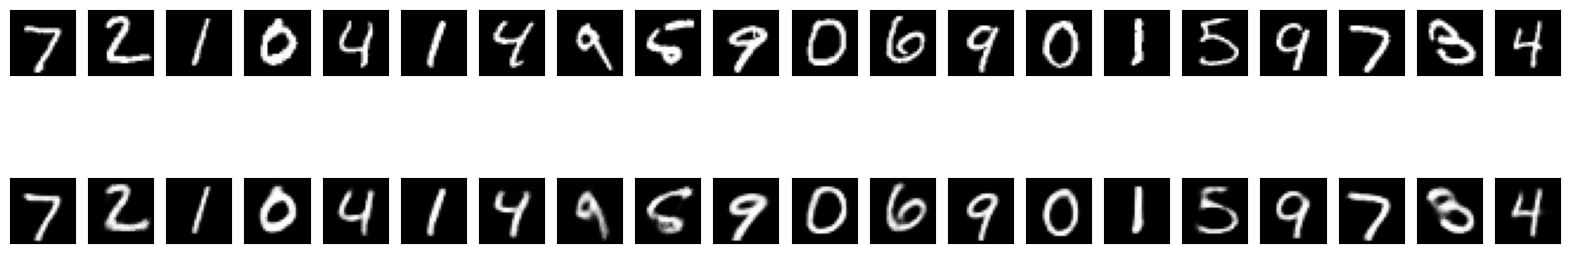

In [81]:
n = 20  # Combien de chiffres nous allons afficher

# Afficher l'image reconstruite à partir de l'espace latent après entraînement
plt.figure(figsize=(20, 4))

for i in range(n):
    # Affichage de l'image originale
    ax = plt.subplot(2, n, i + 1)
    plt.imshow(x_testIm[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # Affichage de l'image reconstruite
    ax = plt.subplot(2, n, i + 1 + n)
    plt.imshow(decoded_imgs[i].reshape(28, 28))
    plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

63/63 [==============================] - 0s 4ms/step


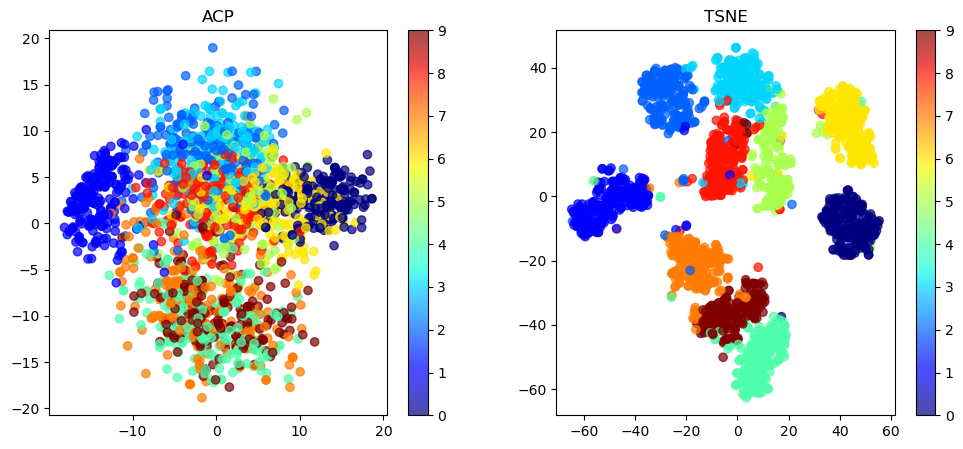

In [82]:
# Affichage de l'espace latent par réduction de dimension 
count=2000
inputs = x_train[ListeData]
classes = y_train[ListeData]

# Récupération des données dans l'espace latent
latent = encoder.predict(inputs)

# Réduction de dimension 2D par ACP
pca = PCA(n_components=2)
inputs_pca = pca.fit_transform(latent)

# Réduction de dimension 2D par la TSNE
tsne = TSNE(n_components=2)
coordsTSNE_AC = tsne.fit_transform(latent)

# Affichage de l'espace latent par ACP et TSNE
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(inputs_pca[:, 0], inputs_pca[:, 1], c=classes, cmap='jet', alpha=0.7)
plt.colorbar()
plt.title('ACP')
plt.subplot(1, 2, 2)
plt.scatter(coordsTSNE_AC[:, 0], coordsTSNE_AC[:, 1], c=classes, cmap='jet', alpha=0.7)
plt.colorbar()
plt.title('TSNE')
plt.show()

In [83]:
# Classification par kmeans de l'espace latent sur l'ensemble d'apprentissage

# Initialisation du Kmeans 
kmeans = MiniBatchKMeans(n_clusters = n_digits)

# Affichage
inputsTrain = x_train
classesTrain = y_train


# Kmeans sur base d'apprentissage
y_pred_kmeans=kmeans.fit_predict(encoder.predict(inputsTrain))

# Score de performance sur l'apprentissage
acc = accuracy_score(classesTrain,correspondance(y_pred_kmeans,classesTrain))

print(f"Performance de l'autoencodeur : {acc}")


1875/1875 [==============================] - 8s 4ms/step


/home/felix/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:1934: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=3)


Performance de l'autoencodeur : 0.7536166666666667


/tmp/ipykernel_38264/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


## Couche de clustering 
maintient les centres de cluster $\mu_j$ comme poids entraînables et projette chaque point intégré $z_i$ en soft label $q_i$ par la distribution $t$ de Student:
$$q_{ij}=\frac{(1+\|z_i-\mu_j\|^2)^{-1}}{\sum_j(1+\|z_i-\mu_j\|^2)^{-1}}$$
où $q_{ij}$ est la $j$ ième entrée de $q_i$, représentant la probabilité d'appartenance de $z_i$ au cluster $j$.

In [85]:
import tensorflow as tf

In [86]:
class ClusteringLayer(Layer):
    """
    La couche de classification convertit l'échantillon d'entrée (caractéristique) en une étiquette souple, c'est-à-dire un vecteur qui représente la probabilité d'appartenance de l'échantillon à chaque groupe.
    probabilité d'appartenance de l'échantillon à chaque cluster. La probabilité est calculée avec la distribution t de student.
    # Exemple
    ```
        model.add(ClusteringLayer(n_clusters=10))
    ```
    # Arguments
        n_clusters : nombre de clusters.
        weights : liste de tableaux Numpy de forme `(n_clusters, n_features)` qui représente les centres de clusters initiaux.
        alpha : paramètre de la distribution t de Student. La valeur par défaut est 1.0.
    # Forme de l'entrée
        Tenseur 2D avec la forme : `(n_samples, n_features)`.
    # Forme en sortie
        Tenseur 2D avec forme : `(n_samples, n_clusters)`.
    """


    def __init__(self, n_clusters, weights=None, alpha=1.0, **kwargs):
        if 'input_shape' not in kwargs and 'input_dim' in kwargs:
            kwargs['input_shape'] = (kwargs.pop('input_dim'),)
        super(ClusteringLayer, self).__init__(**kwargs)
        self.n_clusters = n_clusters
        self.alpha = alpha
        self.initial_weights = weights
        self.input_spec = InputSpec(ndim=2)

    def build(self, input_shape):
        assert len(input_shape) == 2
        input_dim = input_shape[1]
        self.input_spec = InputSpec(dtype=K.floatx(), shape=(None, input_dim))
        self.clusters = self.add_weight(shape=(self.n_clusters, input_dim), initializer='glorot_uniform', name='clusters')
        if self.initial_weights is not None:
            self.set_weights(self.initial_weights)
            del self.initial_weights
        self.built = True

    def call(self, inputs, **kwargs):
      """ Distribution t de student, la même que celle utilisée dans l'algorithme t-SNE.
                 q_ij = 1/(1+dist(x_i, u_j)^2), puis normalisation.
        Arguments :
            inputs : la variable contenant les données, shape=(n_samples, n_features)
        Retourne :
            q : la distribution t de student, ou des étiquettes souples pour chaque échantillon. shape=(n_samples, n_clusters)
        """
      q = 1.0 / (1.0 + (tf.reduce_sum(tf.square(tf.expand_dims(inputs, axis=1) - self.clusters), axis=2) / self.alpha))
      q **= (self.alpha + 1.0) / 2.0
      q = tf.transpose(tf.transpose(q) / tf.reduce_sum(q, axis=1))
      return q

    def compute_output_shape(self, input_shape):
        assert input_shape and len(input_shape) == 2
        return input_shape[0], self.n_clusters

    def get_config(self):
        config = {'n_clusters': self.n_clusters}
        base_config = super(ClusteringLayer, self).get_config()
        return dict(list(base_config.items()) + list(config.items()))


Définition de la distribution $P$ cible définie comme
$$p_{ij}=\frac{q_{ij}^2/\sum_i q_{ij}}{\sum_j (q_{ij}^2/\sum_i q_{ij})}.$$
où $p_{ij}$ est la $j$ ième entrée de $p_i$ représentant la probabilité d'appartenance de la donnée $i$ la classe $j$

In [87]:
# Calcul de la distribution cible
def target_distribution(q):
  weight = q ** 2 / q.sum(0)
  return (weight.T / weight.sum(1)).T

In [88]:
# Configuration de la couche de clustering
clustering_layer = ClusteringLayer(n_clusters, name='clustering')(encoder.output)
model = Model(inputs=encoder.input, outputs=clustering_layer)

model.compile(optimizer="Adam", loss='kld')

# Entrainement du modèle avec la couche de clustering

In [89]:
# paramètres à fixer
loss = 0
index = 0
maxiter =800
update_interval = 140
batch_size=128
index_array = np.arange(x_train.shape[0])
tol = 0.005 # seuil pour critère d'arrêt

In [90]:
#Initialisation Kmeans
kmeans = KMeans(n_clusters=n_clusters, n_init=20)
y_pred = kmeans.fit_predict(encoder.predict(x_train))

# récupération des centres de clusters   
y_pred_last = np.copy(y_pred)
model.get_layer(name='clustering').set_weights([kmeans.cluster_centers_])

for ite in range(int(maxiter)):
    if ite % update_interval == 0:
        q = model.predict(x_train, verbose=0)
        p = target_distribution(q)  # mise à jour de la distribution cible p 

        # evaluation de la performance du clustering 
        y_pred = q.argmax(1)
        if y_train is not None: 
            y_pred=correspondance(y_pred,y_train)
            acc = np.round(accuracy_score(y_train, y_pred), 5)
            loss = np.round(loss, 5)
            print('(Iter , acc)  ',(ite, acc), ' ; loss=', loss)

        # check stop criterion - model convergence
        delta_label = np.sum(y_pred != y_pred_last).astype(np.float32) / y_pred.shape[0]
        y_pred_last = np.copy(y_pred)
        if ite > 0 and delta_label < tol:
            print('delta_label ', delta_label, '< tol ', tol)
            print('Reached tolerance threshold. Stopping training.')
            break
    idx = index_array[index * batch_size: min((index+1) * batch_size, x_train.shape[0])]
    loss = model.train_on_batch(x=x_train[idx], y=p[idx])
    index = index + 1 if (index + 1) * batch_size <= x_train.shape[0] else 0

1875/1875 [==============================] - 8s 4ms/step


/tmp/ipykernel_38264/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (0, 0.76072)  ; loss= 0


/tmp/ipykernel_38264/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (140, 0.76262)  ; loss= 0.03159


/tmp/ipykernel_38264/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (280, 0.76617)  ; loss= 0.06968


/tmp/ipykernel_38264/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (420, 0.77053)  ; loss= 0.07805


/tmp/ipykernel_38264/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (560, 0.77215)  ; loss= 0.1124


/tmp/ipykernel_38264/111057547.py:6: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  number_labels[i] = reference_labels[y_pred_kmeans[i]]


(Iter , acc)   (700, 0.77552)  ; loss= 0.08936


63/63 [==============================] - 0s 4ms/step


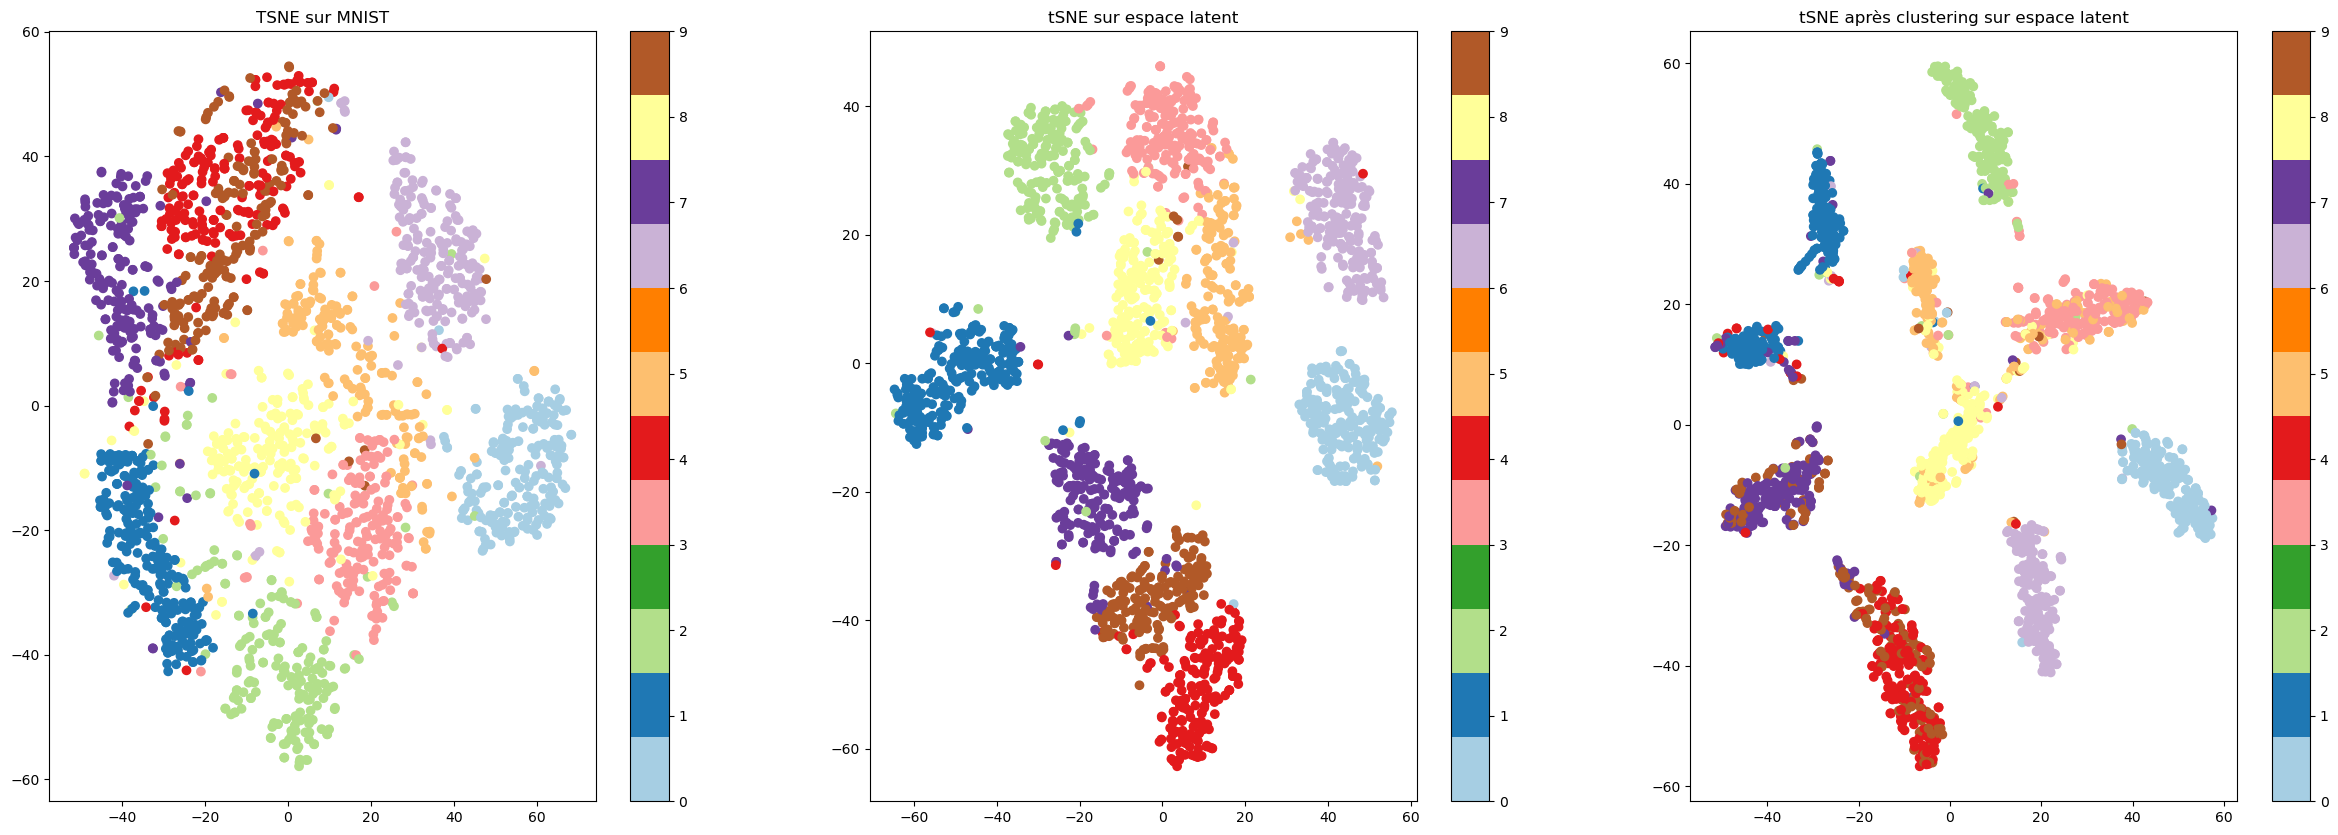

In [91]:
# Affichage de l'impact de cette couche clustering 

inputs = x_train[ListeData]
classes = y_train[ListeData]

# TSNE sur espace latent avec kmeans
coordsAC_V2 = encoder.predict(inputs)
coordsTSNE_V2 = TSNE(n_components=2).fit_transform(coordsAC_V2.reshape(count, -1))


fig2= plt.figure(figsize=(30, 10))
ax2=plt.subplot(1,3,1)
ax2.set_title("TSNE sur MNIST")
plt.scatter(coordsTSNE[:, 0], coordsTSNE[:, 1], c=classes,cmap='Paired')
plt.colorbar()


ax2 = plt.subplot(1,3,2)
ax2.set_title("tSNE sur espace latent")
plt.scatter(coordsTSNE_AC[:, 0], coordsTSNE_AC[:, 1], c=classes,cmap='Paired')
plt.colorbar()



ax2 = plt.subplot(1,3,3)
ax2.set_title("tSNE après clustering sur espace latent")
plt.scatter(coordsTSNE_V2[:, 0], coordsTSNE_V2[:, 1], c=classes,cmap='Paired')
plt.colorbar()

# Passer à la version convolutive de l'autoencodeur

In [ ]:
# Autoencodeur convolutionnel
input_img = Input(shape=(x_train.shape[1],))
n_latent = 10

# Encoder
x = Reshape((28, 28, 1))(input_img)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Flatten()(x)
encoded = Dense(n_latent, activation='linear')(x)
encoder = Model(inputs=input_img, outputs=encoded, name='encoder')

# Decoder
decoder_input = Input(shape=(n_latent,))
x = Dense(7 * 7 * 32, activation='relu')(decoder_input)
x = Reshape((7, 7, 32))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)
decoder = Model(inputs=decoder_input, outputs=decoded, name='decoder')

# Modèle complet
encoded = encoder(input_img)
decoded = decoder(encoded)
autoencoder = Model(inputs=input_img, outputs=decoded, name='autoencoder')